### Importing Libraries

In [109]:
import pandas as pd
import numpy as np
import time
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.isri import ISRIStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.models import Sequential
from keras import layers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import string
import re
import langid
import tensorflow as tf

In [110]:
#pip install --user imbalanced-learn


In [111]:
#pip install langid


In [112]:
#pip install tensorflow

In [113]:
#pip install keras

In [114]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Importing CSV

In [115]:
train = pd.read_csv("/kaggle/input/arabic-sentiment/train.csv")
test = pd.read_csv("/kaggle/input/arabic-sentiment/test _no_label.csv")

### Data Exploratory Analysis

In [116]:
train.head()

,review_description,rating
0,شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...,-1
1,خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...,1
2,تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...,-1
3,فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...,1
4,سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...,-1


In [117]:
test.head()

,ID,review_description
0,1,اهنئكم على خدمه العملاء في المحادثه المباشره م...
1,2,ممتاز جدا ولكن اتمنى ان تكون هناك بعض المسابقا...
2,3,كل محملته يقول تم ايقاف حطيت2 عشان تسوون الخطاء
3,4,شغل طيب
4,5,بعد ماجربت


#### Checking number or rows and columns of the dataframe

In [118]:
print(train.shape)
print(test.shape)

(32036, 2)
(1000, 2)


In [119]:
print(train.dtypes)
print(test.dtypes)

review_description    object
rating                 int64
dtype: object
ID                     int64
review_description    object
dtype: object


#### Checking for nulls

In [120]:
np.sum(train.isnull().any(axis=1))
np.sum(test.isnull().any(axis=1))

0

#### Checking for train data imbalance

In [121]:
train['rating'].value_counts()

rating
 1    19189
-1    11340
 0     1507
Name: count, dtype: int64

#### Checking the number of rows that contains english text

In [122]:
# Count the number of English entries train data
english_entries_count = train[train['review_description'].apply(lambda x: langid.classify(x)[0] == 'en')].shape[0]

print(f"Number of English entries: {english_entries_count}")

Number of English entries: 780


In [123]:
# # Count the number of English entries test data
# english_entries_count_test = test[test['review_description'].apply(lambda x: langid.classify(x)[0] == 'en')].shape[0]

# print(f"Number of English entries: {english_entries_count_test}")

### Data preproccessing

In [124]:
#Remove punctuation
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
combined_punctuations = arabic_punctuations + english_punctuations

def remove_punctuation(text):
    # Define the combined pattern for Arabic and English punctuations
    combined_pattern = '[' + re.escape(combined_punctuations) + ']'

    # Use the re.sub() function to replace punctuation with an empty string
    text_without_punctuation = re.sub(combined_pattern, '', text)

    return text_without_punctuation



In [125]:
#normalize arabic data
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [126]:
#removing emojis
def remove_emojis(text):
    # Define a regular expression pattern for emojis
    emoji_pattern = re.compile("["
                               "\U0001F300-\U0001F5FF"  # symbols & pictographs
                               "\U0001F600-\U0001F64F"  # emoticons
                               "\U0001F680-\U0001F6FF"  # transport & map symbols
                               "\U0001F700-\U0001F77F"  # alchemical symbols
                               "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               "\U0001FA00-\U0001FA6F"  # Chess Symbols
                               "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               "\U00002702-\U000027B0"  # Dingbats
                               "\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove emojis from the text
    text_no_emojis = emoji_pattern.sub("", text)

    return text_no_emojis

In [127]:
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

#### Solving data imbalance problem

In [128]:
# Separate features and target variable
X = train.drop('rating', axis=1)
y = train['rating']

oversampler = RandomOverSampler(sampling_strategy={-1: 19189, 0: 19189, 1: 19189})

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new DataFrame with the resampled data
train= pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='rating')], axis=1)

In [129]:
train['rating'].value_counts()

rating
-1    19189
 1    19189
 0    19189
Name: count, dtype: int64

#### Applying normalization, Removing punctation, emojis and repeated characters

In [130]:
#call data cleaning functions for train & test
train['review_description'] = train['review_description'].apply(remove_punctuation)
train['review_description'] = train['review_description'].apply(normalize_arabic)
train['review_description'] = train['review_description'].apply(remove_emojis)
train['review_description'] = train['review_description'].apply(remove_repeating_char)

In [131]:
test['review_description'] = test['review_description'].apply(remove_punctuation)
test['review_description'] = test['review_description'].apply(normalize_arabic)
test['review_description'] = test['review_description'].apply(remove_emojis)
test['review_description'] = test['review_description'].apply(remove_repeating_char)

#### Removing English text from train & test data

In [132]:
# Identify the language for each row and filter out English entries for train
train = train[train['review_description'].apply(lambda x: langid.classify(x)[0] != 'en')]

# Reset index after removing rows
train = train.reset_index(drop=True)

In [133]:
# # Identify the language for each row and filter out English entries for test
# test = test[test['review_description'].apply(lambda x: langid.classify(x)[0] != 'en')]

# # Reset index after removing rows
# test = test.reset_index(drop=True)

In [134]:
train.head(15)

,review_description,rating
0,شركه زباله و سواقين بتبرشم و مفيش حتي رقم لشكا...,-1
1,خدمه الدفع عن طريق الكي نت توقفت عندي اصبح فقط...,1
2,تطبيق غبي و جاري حذفه عاملين اكواد خصم و لما ن...,-1
3,فعلا تطبيق متاز بس لو في امكانيه يتيح لمستخدم ...,1
4,سيء جدا اسعار رسوم التوصيل لا تمت لواقع ب صله,-1
5,قعد عشرين سنه يدور علي سائق بس اما عن توصيل ال...,0
6,احلئ تطبيق,1
7,رائع واو مدهش,1
8,مکو بس البحرین وعمان وغیره بس العراق مکو یعنی ...,-1
9,تطبيق جميل يستاهل الخمس نجوم,1


In [135]:
train.shape

(55598, 2)

In [136]:
train.to_csv('train_cleaned.csv', index=False)

#### Tokenizing training & test data

In [137]:
#toknize train & test reviews
tokenizer = RegexpTokenizer(r'\w+')
train["review_description"] = train["review_description"].apply(tokenizer.tokenize)

In [138]:
#toknize train & test reviews
tokenizer = RegexpTokenizer(r'\w+')
test["review_description"] = test["review_description"].apply(tokenizer.tokenize)

In [139]:
train.head()

,review_description,rating
0,"[شركه, زباله, و, سواقين, بتبرشم, و, مفيش, حتي,...",-1
1,"[خدمه, الدفع, عن, طريق, الكي, نت, توقفت, عندي,...",1
2,"[تطبيق, غبي, و, جاري, حذفه, عاملين, اكواد, خصم...",-1
3,"[فعلا, تطبيق, متاز, بس, لو, في, امكانيه, يتيح,...",1
4,"[سيء, جدا, اسعار, رسوم, التوصيل, لا, تمت, لواق...",-1


In [140]:
test.head()

,ID,review_description
0,1,"[اهنئكم, علي, خدمه, العملاء, في, المحادثه, الم..."
1,2,"[متاز, جدا, ولكن, اتمني, ان, تكون, هناك, بعض, ..."
2,3,"[كل, محملته, يقول, تم, ايقاف, حطيت2, عشان, تسو..."
3,4,"[شغل, طيب]"
4,5,"[بعد, ماجربت]"


In [141]:
train.shape

(55598, 2)

#### Removing stopping words

In [142]:
#Removing stopping words
stopwords_list = stopwords.words('arabic')
listToStr = ' '.join([str(elem) for elem in stopwords_list]) 
train['review_description']=train["review_description"].apply(lambda x: [item for item in x if item not in stopwords_list])
test['review_description']=test["review_description"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [143]:
train.head()

,review_description,rating
0,"[شركه, زباله, سواقين, بتبرشم, مفيش, حتي, رقم, ...",-1
1,"[خدمه, الدفع, طريق, الكي, نت, توقفت, عندي, اصب...",1
2,"[تطبيق, غبي, جاري, حذفه, عاملين, اكواد, خصم, ن...",-1
3,"[فعلا, تطبيق, متاز, امكانيه, يتيح, لمستخدم, ال...",1
4,"[سيء, جدا, اسعار, رسوم, التوصيل, تمت, لواقع, صله]",-1


In [144]:
test.head()

,ID,review_description
0,1,"[اهنئكم, علي, خدمه, العملاء, المحادثه, المباشر..."
1,2,"[متاز, جدا, اتمني, ان, تكون, المسابقات, والجوا..."
2,3,"[محملته, يقول, تم, ايقاف, حطيت2, عشان, تسون, ا..."
3,4,"[شغل, طيب]"
4,5,[ماجربت]


##### Applying stemming to train and test data

In [145]:
# Create a ISRIS stemmer for Arabic
arabic_stemmer = ISRIStemmer()

# AApply Stemming
train['stemmed_review'] = train['review_description'].apply(lambda x: ' '.join([arabic_stemmer.stem(word) for word in x]))
test['stemmed_review'] = test['review_description'].apply(lambda x: ' '.join([arabic_stemmer.stem(word) for word in x]))


In [146]:
train.head()

,review_description,rating,stemmed_review
0,"[شركه, زباله, سواقين, بتبرشم, مفيش, حتي, رقم, ...",-1,شرك زبل سوق رشم فيش حتي رقم شكو سوق يسب يمش مي...
1,"[خدمه, الدفع, طريق, الكي, نت, توقفت, عندي, اصب...",1,خدم دفع طرق الك نت وقف عند اصبح فقط دفع نقد
2,"[تطبيق, غبي, جاري, حذفه, عاملين, اكواد, خصم, ن...",-1,طبق غبي جري حذف عمل كود خصم خدم كتر مره عملو ب...
3,"[فعلا, تطبيق, متاز, امكانيه, يتيح, لمستخدم, ال...",1,فعل طبق تاز مكن يتح خدم طبق ان تطع تغر كلم لسر...
4,"[سيء, جدا, اسعار, رسوم, التوصيل, تمت, لواقع, صله]",-1,سيء جدا سعر رسم وصل تمت لقع صله


In [147]:
test.head()

,ID,review_description,stemmed_review
0,1,"[اهنئكم, علي, خدمه, العملاء, المحادثه, المباشر...",هنئ علي خدم عملاء حدث بشر قصرو اله وفق يعط الف...
1,2,"[متاز, جدا, اتمني, ان, تكون, المسابقات, والجوا...",تاز جدا اتم ان تكون سبق جئز طلب سعد فسف يكون خ...
2,3,"[محملته, يقول, تم, ايقاف, حطيت2, عشان, تسون, ا...",حمل يقل تم يقف حطيت2 عشن تسن خطء
3,4,"[شغل, طيب]",شغل طيب
4,5,[ماجربت],اجرب


In [148]:
train.shape

(55598, 3)

#### Word embedding and model Training

In [149]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['stemmed_review'])
tokenizer.fit_on_texts(test['stemmed_review'])
sequences_train = tokenizer.texts_to_sequences(train['stemmed_review'])
sequences_test = tokenizer.texts_to_sequences(test['stemmed_review'])
reviews_train = pad_sequences(sequences_train, maxlen=max_len)
reviews_test =  pad_sequences(sequences_test, maxlen=max_len)
print(reviews_train)


[[   0    0    0 ...  156  155 1490]
 [   0    0    0 ...  167   91  649]
 [   0    0    0 ...  470  126  505]
 ...
 [   0    0    0 ... 2029    8 2317]
 [   0    0    0 ...    0    0 1735]
 [   0    0    0 ...    0 1963  693]]


In [150]:
print(reviews_test)

[[  0   0   0 ... 260 593 500]
 [  0   0   0 ...   8  14  44]
 [  0   0   0 ...  94 987 446]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 175  45 937]
 [  0   0   0 ... 171 159   6]]


In [151]:
X = reviews_train
Y = train['rating']

In [152]:
Y.shape

(55598,)

In [153]:
X.shape

(55598, 200)

#### Train test split

In [154]:
# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

In [186]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split the temporary data into validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [187]:
# class mapping -1 --> 0 , 1--> 0 1-->2
class_mapping = {-1: 0, 0: 1, 1: 2}

# Map labels for training and validation sets
y_train = [class_mapping[label] for label in y_train]
y_test  = [class_mapping[label] for label in y_test]
y_val  = [class_mapping[label] for label in y_val]

In [183]:
# class_mapping = {0: -1, 1: 0, 2: 1}

# # Map labels for training and validation sets
# y_train = [class_mapping[label] for label in y_train]
# y_test  = [class_mapping[label] for label in y_test]

In [184]:
embedding_layer = Embedding(1000, 64)

In [188]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))  # Specify input length
model1.add(layers.LSTM(15, dropout=0.5))
model1.add(layers.Dense(3, activation='softmax'))  # Change the number of units to match the number of classes
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 20)          100000    
                                                                 
 lstm_3 (LSTM)               (None, 15)                2160      
                                                                 
 dense_11 (Dense)            (None, 3)                 48        
                                                                 
Total params: 102208 (399.25 KB)
Trainable params: 102208 (399.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [189]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint1 = ModelCheckpoint("best_model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1, save_weights_only=False)

# Ensure labels are one-hot encoded
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)

# Ensure y_test is a numpy array
y_train_one_hot  = np.array(y_train_one_hot)
X_train = np.array(X_train)
y_test_one_hot = np.array(y_test_one_hot)
X_test = np.array(X_test)
y_val_one_hot = np.array(y_val_one_hot)
X_val = np.array(X_val)


# Record the start time for training
start_time_training = time.time()

#train model
history = model1.fit(X_train, y_train_one_hot, epochs=2, validation_data=(X_val, y_val_one_hot), callbacks=[checkpoint1])

# Record the ending time for training
end_time_training = time.time()

#save the best model
model1.save('best_model1.h5')
# Load the best model
best_model = load_model("best_model1.h5")

# Record the start time for testing
start_time_testing = time.time()

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_one_hot, verbose=0)

# Record the end time for testing
end_time_testing = time.time()

# Print the results
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Training Time:", end_time_training - start_time_training)
print("Testing Time:", end_time_testing - start_time_testing)

Epoch 1/2
1108/1112 [============================>.] - ETA: 0s - loss: 0.7983 - accuracy: 0.6465
Epoch 1: val_accuracy improved from -inf to 0.76697, saving model to best_model1.h5
1112/1112 [==============================] - 34s 29ms/step - loss: 0.7979 - accuracy: 0.6468 - val_loss: 0.6135 - val_accuracy: 0.7670
Epoch 2/2
   7/1112 [..............................] - ETA: 9s - loss: 0.6333 - accuracy: 0.7589 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1109/1112 [============================>.] - ETA: 0s - loss: 0.5713 - accuracy: 0.7807
Epoch 2: val_accuracy improved from 0.76697 to 0.79732, saving model to best_model1.h5
1112/1112 [==============================] - 13s 11ms/step - loss: 0.5708 - accuracy: 0.7810 - val_loss: 0.5284 - val_accuracy: 0.7973
Test Loss: 0.5315570831298828
Test Accuracy: 0.7981114983558655
Training Time: 46.80907964706421
Testing Time: 1.9084861278533936


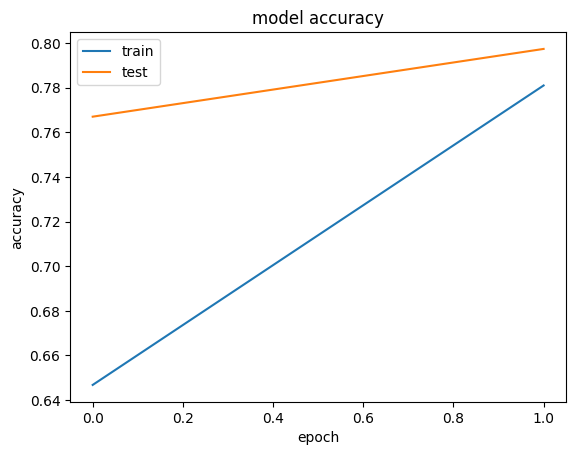

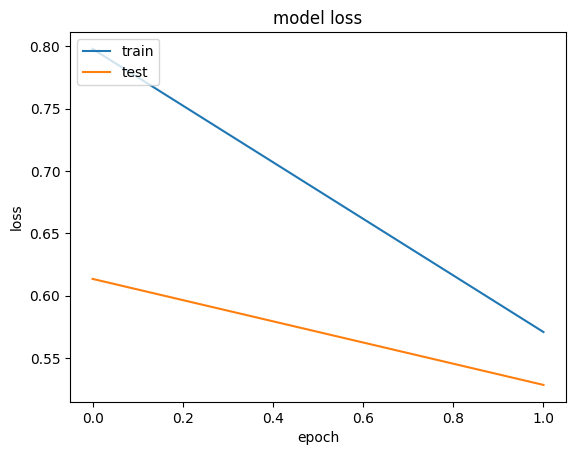

In [190]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [191]:
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

### Loading and testing the LSTM model

In [192]:
# Load the history from the file
with open('history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

In [193]:
loaded_LSTM = load_model('best_model1.h5')

#### Plot training vs test accuracy

In [ ]:
# Predict on the test data
y_pred_probs = loaded_LSTM.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Evaluate the model
accuracy = accuracy_score(y_test,y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_rep)

In [ ]:
# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Predict labels of test data

In [ ]:
test.head()

In [ ]:
predicted_reviews = pd.read_csv("/kaggle/input/arabic-sentiment/test _no_label.csv")

In [ ]:
predictions = loaded_LSTM.predict(reviews_test)

In [ ]:
predicted_labels = [np.argmax(pred) for pred in predictions]

In [ ]:
predicted_reviews['reviews'] = predicted_labels

#  map the numeric labels back to original classes
label_mapping = {
    0: -1,
    1: 0,
    2: 1
}

# Map the numeric labels to their corresponding classes
predicted_reviews['reviews'] = predicted_reviews['reviews'].map(label_mapping)


In [ ]:
predicted_reviews.head()

In [ ]:
predicted_reviews.to_csv('LSTM_predications.csv', index=False)

# **Transformer model**

# Attention layer

In [194]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embed_dim must be divisible by num_heads, got {embed_dim} and {num_heads}")

        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

# Transformer block layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(1e-4)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Position embedding layer

In [195]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# The transformer model

In [210]:
class TransformerModel(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dim, output_dim, rate=0.5):
        super(TransformerModel, self).__init__()

        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        self.dropout1 = layers.Dropout(rate)
        self.dense1 = layers.Dense(20, activation="relu", kernel_regularizer=regularizers.l2(1e-2))
        self.dropout2 = layers.Dropout(rate)
        self.dense2 = layers.Dense(output_dim, activation="softmax", kernel_regularizer=regularizers.l2(1e-2))

    def call(self, inputs, training):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x, training=training)
        x = self.global_avg_pooling(x)
        x = self.dropout1(x, training=training)
        x = self.dense1(x)
        x = self.dropout2(x, training=training)
        return self.dense2(x)
    

# Training the model

In [211]:
max_words = 5000
maxlen = 200
embed_dim = 32
num_heads = 8
ff_dim = 64
output_dim = 3

inputs = layers.Input(shape=(200,))
transformer_model = TransformerModel(maxlen, max_words, embed_dim, num_heads, ff_dim, output_dim)

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
transformer_model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric])

# Early Stopping callback to stop training if the validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


start_time = time.time()
# Train the model with the Early Stopping callback
history = transformer_model.fit(X_train, y_train_one_hot, epochs=100, validation_data=(X_val, y_val_one_hot), callbacks=[early_stopping])
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")





Epoch 1/100
1112/1112 [==============================] - 40s 32ms/step - loss: 1.2115 - categorical_accuracy: 0.3388 - val_loss: 1.1180 - val_categorical_accuracy: 0.3312
Epoch 2/100
1112/1112 [==============================] - 15s 14ms/step - loss: 0.9438 - categorical_accuracy: 0.5428 - val_loss: 0.7340 - val_categorical_accuracy: 0.7383
Epoch 3/100
1112/1112 [==============================] - 14s 13ms/step - loss: 0.7050 - categorical_accuracy: 0.7681 - val_loss: 0.6031 - val_categorical_accuracy: 0.8064
Epoch 4/100
1112/1112 [==============================] - 14s 13ms/step - loss: 0.5896 - categorical_accuracy: 0.8250 - val_loss: 0.5638 - val_categorical_accuracy: 0.8198
Epoch 5/100
1112/1112 [==============================] - 13s 12ms/step - loss: 0.5328 - categorical_accuracy: 0.8478 - val_loss: 0.5349 - val_categorical_accuracy: 0.8333
Epoch 6/100
1112/1112 [==============================] - 13s 12ms/step - loss: 0.4913 - categorical_accuracy: 0.8629 - val_loss: 0.5873 - val_cat

In [212]:
transformer_model.save("transformer_model", save_format="tf")
# Load the saved model
loaded_model = tf.keras.models.load_model("transformer_model")

# Testing the model

In [213]:
results = loaded_model.evaluate(X_test, y_test_one_hot)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

348/348 [==============================] - 2s 5ms/step - loss: 0.5170 - categorical_accuracy: 0.8506
Test Loss: 0.5169687867164612
Test Accuracy: 0.8506295084953308


# Checking for overfitting

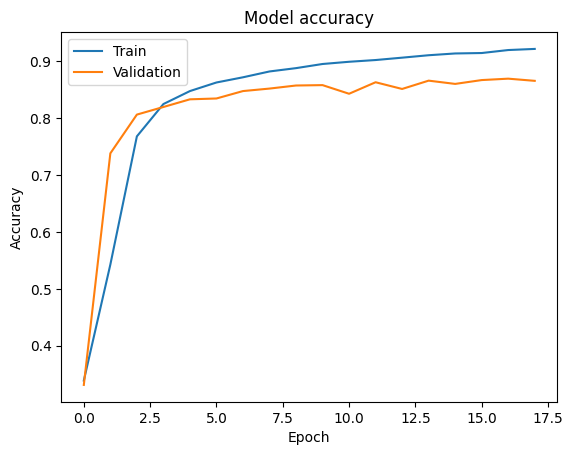

In [214]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


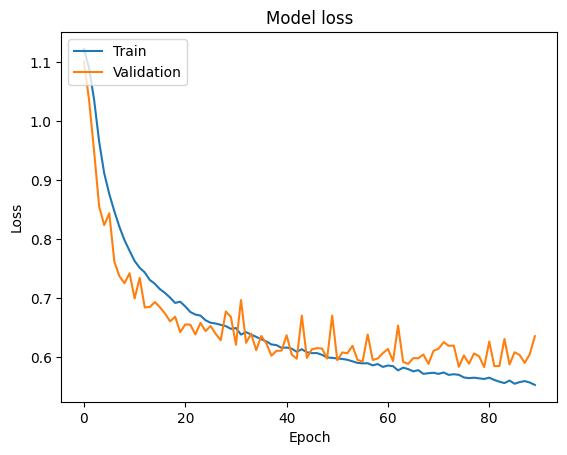

In [201]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [202]:
# Predict on the test data
y_pred_probs = loaded_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_rep)

348/348 [==============================] - 2s 4ms/step
Accuracy: 0.8042
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      3800
           1       0.78      0.84      0.81      3752
           2       0.79      0.79      0.79      3568

    accuracy                           0.80     11120
   macro avg       0.81      0.80      0.80     11120
weighted avg       0.81      0.80      0.80     11120



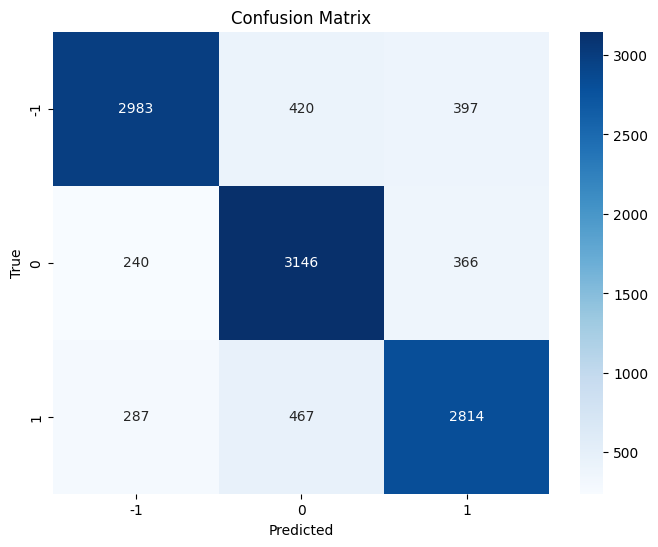

In [203]:
# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Testing the model**

In [217]:
predicted_reviews = pd.read_csv("/kaggle/input/arabic-sentiment/test _no_label.csv")
#call data cleaning functions for train & test
predicted_reviews['review_description'] = predicted_reviews['review_description'].apply(remove_punctuation)
predicted_reviews['review_description'] = predicted_reviews['review_description'].apply(normalize_arabic)
predicted_reviews['review_description'] = predicted_reviews['review_description'].apply(remove_emojis)
predicted_reviews['review_description'] = predicted_reviews['review_description'].apply(remove_repeating_char)


# Identify the language for each row and filter out English entries for train
predicted_reviews = predicted_reviews[predicted_reviews['review_description'].apply(lambda x: langid.classify(x)[0] != 'en')]

# Reset index after removing rows
predicted_reviews = predicted_reviews.reset_index(drop=True)

In [218]:
#toknize train & test reviews
tokenizer = RegexpTokenizer(r'\w+')
predicted_reviews["review_description"] = predicted_reviews["review_description"].apply(tokenizer.tokenize)

#Removing stopping words
stopwords_list = stopwords.words('arabic')
listToStr = ' '.join([str(elem) for elem in stopwords_list]) 
predicted_reviews['review_description']=predicted_reviews["review_description"].apply(lambda x: [item for item in x if item not in stopwords_list])


In [219]:
# Create a ISRIS stemmer for Arabic
arabic_stemmer = ISRIStemmer()

# AApply Stemming
predicted_reviews['stemmed_review'] = predicted_reviews['review_description'].apply(lambda x: ' '.join([arabic_stemmer.stem(word) for word in x]))



In [220]:


tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(predicted_reviews['stemmed_review'])
sequences_train = tokenizer.texts_to_sequences(predicted_reviews['stemmed_review'])
final = pad_sequences(sequences_train, maxlen=max_len)



In [222]:
predictions = transformer_model.predict(final)

predicted_labels = [np.argmax(pred) for pred in predictions]


31/31 [==============================] - 0s 4ms/step


In [223]:
predicted_reviews['reviews'] = predicted_labels

#  map the numeric labels back to original classes
label_mapping = {
    0: -1,
    1: 0,
    2: 1
}

# Map the numeric labels to their corresponding classes
predicted_reviews['reviews'] = predicted_reviews['reviews'].map(label_mapping)


In [226]:
predicted_reviews.to_csv('final.csv', index=False)